In [1]:
#fixando uma seed para as simulações
set.seed(11298601)

In [2]:
#instalando bibliotecas de visualização
install.packages('KernSmooth')
install.packages("ggplot2")
install.packages("latex2exp")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
#chamando as bibliotecas de visualização
library('KernSmooth')
library(ggplot2)
library(latex2exp)

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009



In [4]:
#dados a serem usados
data = read.table('trottaSNe_simulated.dat',header=TRUE)#,skip=3)

In [6]:
#selecionando as colunas dos dados que nos seram úteis (a saber, o redshift e a magnitude aparente)
z = data[,1]
m = data[,2]

In [7]:
#parametros fixados

#magnitude absoluta
M_0 = -19.3
#costante de hubble/100
h = 0.72
#velocidadde da luz (aproximado)
c=300000
#erro nos dados
sigma = 0.4

#valores reais dos parametros cosmológicos (densidade de matéria (barionica + escura) e densidade de energia escura)
Om_m_0=0.3
Om_l_0=0.7

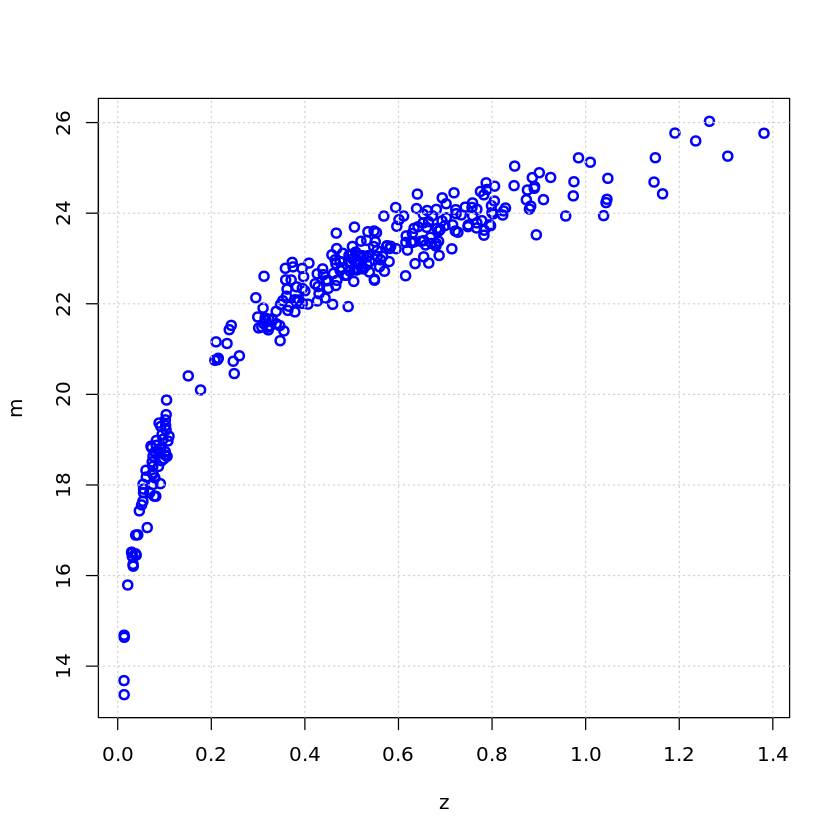

In [46]:
#plot dos dados (x=redshift, y=magnitudade aparente)
plot(z,m,lwd=2,col='blue')
grid()

#arrows(x0=z, y0=m-sigma, x1=z, y1=m+sigma, code=3, angle=90, length=0.05)

* $ \hat{\mu}_i = m_i - M_0 $

* $ \mu_i(z_i,\Omega_m,\Omega_\Lambda,h) = \eta + 5 \log{d_L(z_i,\Omega_m,\Omega_\Lambda)} $ , onde $ \eta = -5 \log{ \dfrac{100h}{c} + 25} $



* $ d_L(z_i,\Omega_m,\Omega_\Lambda): \\ $
$-$ Se $(\Omega_m+\Omega_\Lambda = 1)$ então: $ d_L=(1+z) \int_0^z dz'[(1+z')^3\Omega_m+\Omega_\Lambda+(1+z')^2(1-\Omega_m-\Omega_\Lambda)]^{-\dfrac{1}{2}}\\ $

   $-$ Se $(\Omega_m+\Omega_\Lambda > 1)$ então: $ d_L=\dfrac{(1+z)}{\sqrt{|1-\Omega_m-\Omega_\Lambda|}} \sin\left( \sqrt{|1-\Omega_m-\Omega_\Lambda|} \int_0^z dz'[(1+z')^3\Omega_m+\Omega_\Lambda+(1+z')^2(1-\Omega_m-\Omega_\Lambda)]^{-\dfrac{1}{2}}\right)\\ $

   $-$ Se $(\Omega_m+\Omega_\Lambda < 1)$ então: $ d_L=\dfrac{(1+z)}{\sqrt{|1-\Omega_m-\Omega_\Lambda|}} \sinh\left( \sqrt{|1-\Omega_m-\Omega_\Lambda|} \int_0^z dz'[(1+z')^3\Omega_m+\Omega_\Lambda+(1+z')^2(1-\Omega_m-\Omega_\Lambda)]^{-\dfrac{1}{2}}\right)\\ $

A likelihood para cada SNIa é dada por:

* $ L_i = -\dfrac{1}{\sqrt{2\pi}\sigma}\exp{\left(-\dfrac{1}{2}\dfrac{(\hat{\mu_i}-\mu_i)^2}{\sigma^2}\right)}$

O produto de todas as likelihood é:

* $ L = \prod_i L_i = \left( \frac{1}{\sqrt{2\pi}\sigma} \right)^n \exp{\left( \sum_i -\dfrac{1}{2}\dfrac{(\hat{\mu_i}-\mu_i)^2}{\sigma^2} \right)} $

$ \ln{L} = n \ln\left( \dfrac{1}{\sqrt{2\pi}\sigma} \right) - \dfrac{1}{2\sigma^2}\sum_i (\hat{\mu_i}-\mu_i)^2 $

### a)

In [9]:
#intergando (argumento da integral) da distância luminosa d_L
integrand=function(x,Om_m,Om_l){
    out = (Om_m*(1+x)^3+Om_l+(1-Om_m-Om_l)*(1+x)^2)^(-0.5)
}

In [10]:
#resultado numérico da integral do integrando
integral=function(zi,param1,param2){
return(integrate(integrand,lower=0,upper=zi,Om_m=param1,Om_l=param2)$val)
}

In [24]:
#parâmetros para o mcmc
npar_a = 2
param=NULL
len_data=length(z)

#likelihood
log_lkhd = function(param){

d_L=NULL

if(param[1]+param[2]==1){
    j=1
    for(i in 1:len_data){
        d_L[i]=(1+z[i])*integral(z[i],param[1],param[2])
        j=j+1
        }
}else if(param[1]+param[2]>1){
    j=1
    for(i in 1:len_data){
        d_L[i]=(1+z[i])/sqrt(abs(1-param[1]-param[2]))*sin(sqrt(abs(1-param[1]-param[2]))*integral(z[i],param[1],param[2]))
        j=j+1
        }
}else if(param[1]+param[2]<1){
    j=1
    for(i in 1:len_data){
        d_L[i]=(1+z[i])/sqrt(abs(1-param[1]-param[2]))*sinh(sqrt(abs(1-param[1]-param[2]))*integral(z[i],param[1],param[2]))
        j=j+1
        }
}

#diferença entre magnitude aparente e absoluta (modulo de distancia mû)
muh_i=NULL
for(i in 1:len_data){
muh_i[i]=m[i]-M_0
}

# modulo de distancia atraves da distancia luminosa
mu_zi=NULL
ni=-5*log10(100*h/c)+25
for(i in 1:len_data){
mu_zi[i]=ni+5*log10(d_L[i])
}

return(-len_data*log(sqrt(2*pi)*sigma)-(0.5/sigma^2)*sum((muh_i-mu_zi)^2))
}

**Priores:**

$P(\Omega_m,\Omega_\Lambda)=P(\Omega_m)P(\Omega_\Lambda)=cte$
 
em log:

$lnP(\Omega_m,\Omega_\Lambda)=lnP(\Omega_m)+lnP(\Omega_\Lambda)$

In [25]:
#prior uniforme
logprior = function(param){ 
  logpr_Om_m = dunif(param[1], min=0, max=3, log = T)
  logpr_Om_l = dunif(param[2], min=0, max=3, log = T)
  return(logpr_Om_m+logpr_Om_l)}

Posterior: $P=L \cdot p$ , em que $L$ = likelihood, $p$ = prior 

em log:

$ \ln P = \ln L + \ln p $

In [26]:
#logaritimo do posterior P
logposterior = function(param){log_lkhd(param) + logprior(param)}

Para isso vamos adotar uma função proposta: $N(0,0.1)$ para cada parâmetro

In [27]:
funcao_proposta = function(param){rnorm(npar_a,mean = param, sd= rep(0.1,npar_a))}

In [28]:
#algoritimo mcmc
mcmc = function(xini, niter){
    cadeia = array(dim = c(niter+1,npar_a))
    cadeia[1,] = xini
    for (i in 1:niter){
        proposta = funcao_proposta(cadeia[i,])
        probml = exp(logposterior(proposta) - logposterior(cadeia[i,]))
        ifelse ((runif(1) < probml),
            yes = (cadeia[i+1,] = proposta),
            no = (cadeia[i+1,] = cadeia[i,]))
    }    
    return(cadeia)
}

Simulação MCMC:

In [29]:
# simulacao
set.seed(11298601)
xinicial_a = c(0.5,0.5)
nsim=10000
simulacao = mcmc(xinicial_a, nsim)

# vamos supor um burn-in de 1000 iterações:
# (o objetivo do burn-in é remover as simulações iniciais, que podem estar fora da região de maior probabilidade dos parâmetros)
burnin=1000

# taxa de aceitação
aceitacao = 1-mean(duplicated(simulacao[-(1:burnin),]))
aceitacao

0.414509498944562

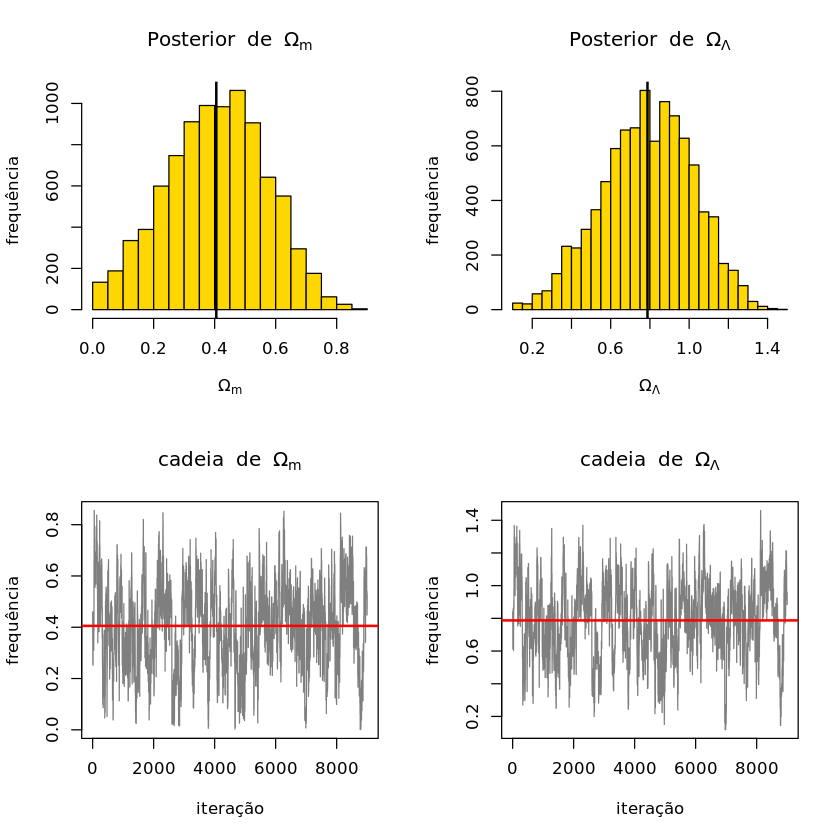

In [30]:
# visualização, sem o burn-in
# a linha vermelha é o valor médio do parâmetro
par(mfrow = c(2,2))
hist(simulacao[-(1:burnin),1],breaks=30, main=TeX("$Posterior \\ de \\ \\Omega_m$"), xlab=TeX("$\\Omega_m$"),ylab='frequência',col='gold')
abline(v = mean(simulacao[-(1:burnin),1]),lwd=2)
hist(simulacao[-(1:burnin),2],breaks=30, main=TeX("$Posterior \\ de \\ \\Omega_\\Lambda$"), xlab=TeX("$\\Omega_\\Lambda$"),ylab='frequência',col='gold')
abline(v = mean(simulacao[-(1:burnin),2]),lwd=2)
plot(simulacao[-(1:burnin),1], type = "l", xlab="iteração" , main = TeX("$cadeia \\ de \\ \\Omega_m$"),ylab='frequência',col='gray50')
abline(h = mean(simulacao[-(1:burnin),1]), col="red",lwd=2)
plot(simulacao[-(1:burnin),2], type = "l", xlab="iteração" , main =  TeX("$cadeia \\ de \\ \\Omega_\\Lambda$"),ylab='frequência',col='gray50')
abline(h = mean(simulacao[-(1:burnin),2]), col="red",lwd=2)

In [41]:
Om_m_cadeia=simulacao[-(1:burnin),1]
Om_l_cadeia=simulacao[-(1:burnin),2]

Om_m_mean=mean(Om_m_cadeia)
Om_l_mean=mean(Om_l_cadeia)

Om_m_sd=sd(Om_m_cadeia)
Om_l_sd=sd(Om_m_cadeia)

Warning message:
“Removed 5 rows containing non-finite values (`stat_density2d()`).”


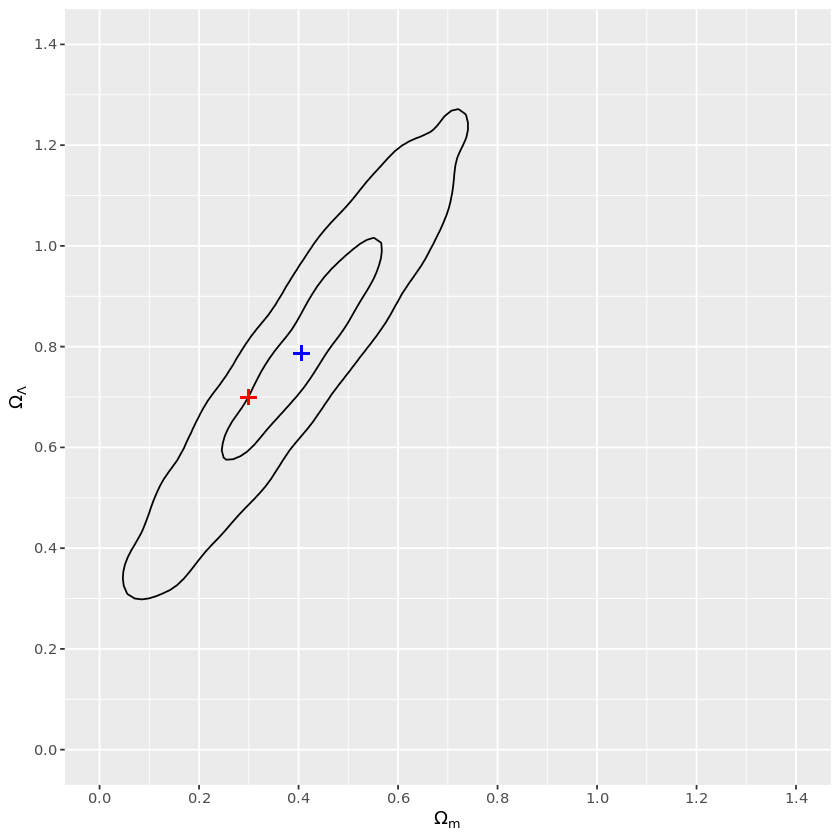

In [42]:
# Plot do resultado em curvas de nível (ponto vermelho = parametros reais, ponto azul = parametros simulados)
Z = cbind(Om_m_cadeia,Om_l_cadeia)
df <- data.frame(x = Z[,1], y = Z[,2])

ggplot(df, aes(x = x, y = y)) +
scale_x_continuous( limits=c(0, 1.4),breaks=seq(0,1.4,0.2)) + 
xlab(TeX("$\\Omega_m$")) +
scale_y_continuous(limits=c(0, 1.4),breaks=seq(0,1.4,0.2)) +
ylab(TeX("$\\Omega_\\Lambda$")) +
  geom_density_2d(breaks=c(7,1.5),col='black') +
  geom_point(aes(x = Om_m_0, y = Om_l_0), shape="+", color = "red", size = 5) +
  geom_point(aes(x = Om_m_mean, y = Om_l_mean), shape="+", color = "blue", size = 5)

### b) agora adicionamos o parametro $\sigma$, o qual também vamos iferir seu valor

* $ \hat{\mu}_i = m_i - M_0 $

* $ \mu_i(z_i,\Omega_m,\Omega_\Lambda,h) = \eta + 5 \log{d_L(z_i,\Omega_m,\Omega_\Lambda)} $ , onde $ \eta = -5 \log{ \dfrac{100h}{c} + 25} $


* $ L_i = -\dfrac{1}{\sqrt{2\pi}\sigma_i}\exp{\left(-\dfrac{1}{2}\dfrac{(\hat{\mu_i}-\mu_i)^2}{\sigma_i^2}\right)}
= -\dfrac{1}{\sqrt{2\pi}}\exp{\left(-\dfrac{1}{2}\dfrac{(\hat{\mu_i}-\mu_i)^2}{\sigma_i^2}-\ln{\sigma_i}\right)}
$

* $ L = \prod_i L_i = \left( \frac{1}{\sqrt{2\pi}} \right)^n \exp{\left( \sum_i -\dfrac{1}{2}\dfrac{(\hat{\mu_i}-\mu_i)^2}{\sigma_i^2}-\ln{\sigma_i}\right)} $

In [34]:
#a likelihood vai mudar um pouco
npar_b = 3
param=NULL
len_data=length(z)

log_lkhd_b = function(param){

d_L=NULL

if(param[1]+param[2]==1){
    j=1
    for(i in 1:len_data){
        d_L[i]=(1+z[i])*integral(z[i],param[1],param[2])
        j=j+1
        }
}else if(param[1]+param[2]>1){
    j=1
    for(i in 1:len_data){
        d_L[i]=(1+z[i])/sqrt(abs(1-param[1]-param[2]))*sin(sqrt(abs(1-param[1]-param[2]))*integral(z[i],param[1],param[2]))
        j=j+1
        }
}else if(param[1]+param[2]<1){
    j=1
    for(i in 1:len_data){
        d_L[i]=(1+z[i])/sqrt(abs(1-param[1]-param[2]))*sinh(sqrt(abs(1-param[1]-param[2]))*integral(z[i],param[1],param[2]))
        j=j+1
        }
}

muh_i=NULL
for(i in 1:len_data){
muh_i[i]=m[i]-M_0
}

mu_zi=NULL
ni=-5*log10(100*h/c)+25
for(i in 1:len_data){
mu_zi[i]=ni+5*log10(d_L[i])
}

return(-len_data*log(sqrt(2*pi))-0.5*sum((muh_i-mu_zi)^2-log(param[3])/param[3]^2))
}

prior novo:

$P(\Omega_m,\Omega_\Lambda,\sigma)=P(\Omega_m)P(\Omega_\Lambda)P(\sigma)=cte$
 
em log:

$\ln{P(\Omega_m,\Omega_\Lambda,\sigma)}=\ln{P(\Omega_m)}+\ln{P(\Omega_\Lambda)}+\ln{P(\sigma)}$ , $P(\sigma)=\dfrac{1}{\sigma}$

$ \implies \ \ln{P(\Omega_m,\Omega_\Lambda,\sigma)}=\ln{P(\Omega_m)}+\ln{P(\Omega_\Lambda)}-\ln{\sigma} $

In [35]:
#novo prior
logprior_b = function(param){ 
  logpr_Om_m = dunif(param[1], min=0, max=3, log = T)
  logpr_Om_l = dunif(param[2], min=0, max=3, log = T)
  logpr_sigma = dunif(param[3], min=0.2, max=100, log=T)
  return(logpr_Om_m+logpr_Om_l-logpr_sigma)}

In [36]:
logposterior_b = function(param){log_lkhd_b(param) + logprior_b(param)}

In [43]:
funcao_proposta_b = function(param){rnorm(npar_b,mean = param, sd= rep(0.1,npar_b))}

In [44]:
mcmc_b = function(xini, niter){
    cadeia = array(dim = c(niter+1,npar_b))
    cadeia[1,] = xini
    for (i in 1:niter){
        proposta = funcao_proposta_b(cadeia[i,])
        probml = exp(logposterior_b(proposta) - logposterior_b(cadeia[i,]))
        ifelse ((runif(1) < probml),
            yes = (cadeia[i+1,] = proposta),
            no = (cadeia[i+1,] = cadeia[i,]))
    }    
    return(cadeia)
}

In [45]:
# simulacao b
set.seed(11298601)
xinicial_b = c(0.5,0.5,0.5)
nsim=10000
simulacao_b = mcmc_b(xinicial_b, nsim)

In [94]:
# vamos supor um burn-in de 1000 iterações:
# (o objetivo do burn-in é remover as simulações iniciais, que podem estar fora da região de maior probabilidade dos parâmetros)
burnin=1000

# taxa de aceitação
aceitacao_b = 1-mean(duplicated(simulacao_b[-(1:burnin),]))
aceitacao_b

0.613376291523164

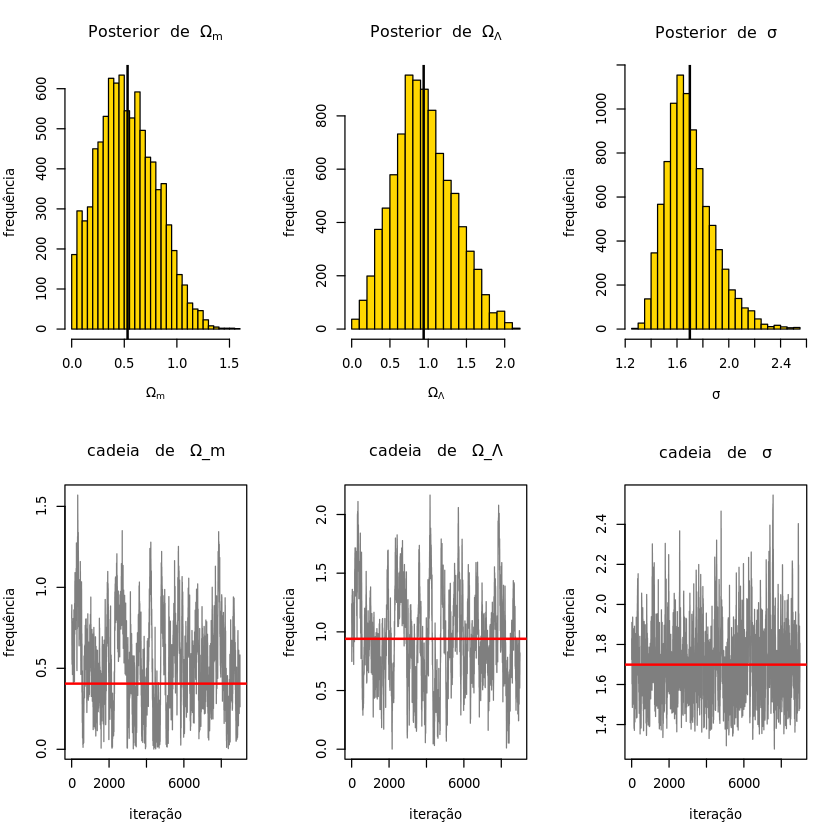

In [95]:
# visualização, sem o burn-in
# a linha vermelha é o valor médio do parâmetro
par(mfrow = c(2,3))

hist(simulacao_b[-(1:burnin),1],breaks=30, main=TeX("$Posterior \\ de \\ \\Omega_m$"), xlab=TeX("$\\Omega_m$"),ylab='frequência',col='gold')
abline(v = mean(simulacao_b[-(1:burnin),1]),lwd=2)
hist(simulacao_b[-(1:burnin),2],breaks=30, main=TeX("$Posterior \\ de \\ \\Omega_\\Lambda$"), xlab=TeX("$\\Omega_\\Lambda$"),ylab='frequência',col='gold')
abline(v = mean(simulacao_b[-(1:burnin),2]),lwd=2)
hist(simulacao_b[-(1:burnin),3],breaks=30, main=TeX("$Posterior \\ de \\ \\sigma$"), xlab=TeX("\\sigma"),ylab='frequência',col='gold')
abline(v = mean(simulacao_b[-(1:burnin),3]),lwd=2)

plot(simulacao_b[-(1:burnin),1], type = "l", xlab="iteração" , main = TeX("cadeia \\ de \\ \\Omega_m"),ylab='frequência',col='gray50')
abline(h = mean(simulacao[-(1:burnin),1]), col="red",lwd=2)
plot(simulacao_b[-(1:burnin),2], type = "l", xlab="iteração" , main =  TeX("cadeia \\ de \\ \\Omega_\\Lambda"),ylab='frequência',col='gray50')
abline(h = mean(simulacao_b[-(1:burnin),2]), col="red",lwd=2)
plot(simulacao_b[-(1:burnin),3], type = "l", xlab="iteração" , main =  TeX("cadeia \\ de \\ \\sigma"),ylab='frequência',col='gray50')
abline(h = mean(simulacao_b[-(1:burnin),3]), col="red",lwd=2)

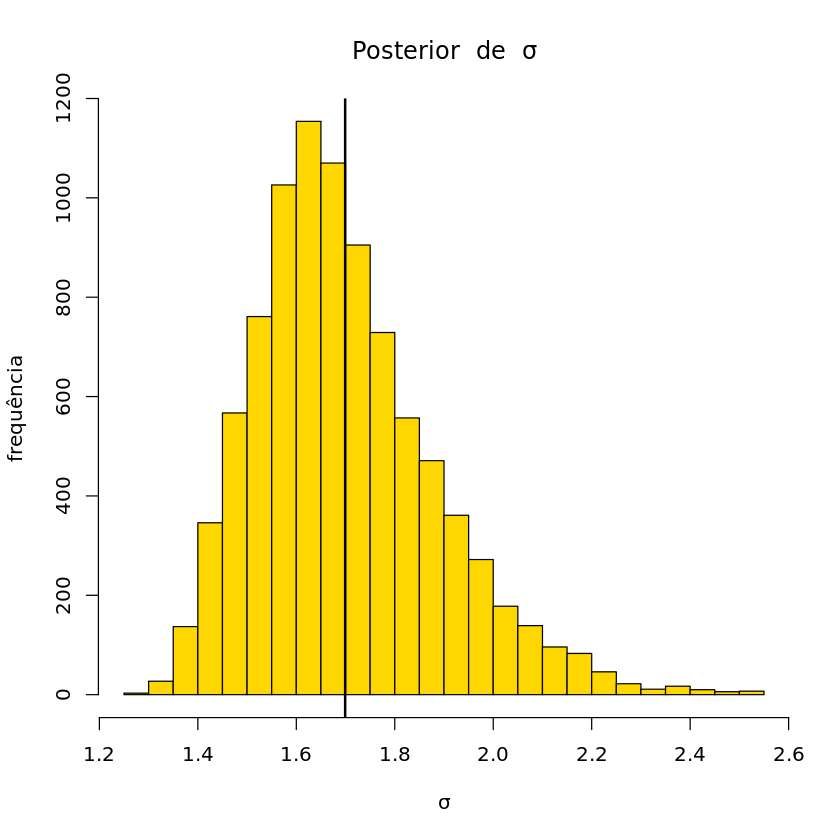

In [96]:
hist(simulacao_b[-(1:burnin),3],breaks=30, main=TeX("$Posterior \\ de \\ \\sigma$"), xlab=TeX("\\sigma"),ylab='frequência',col='gold')
abline(v = mean(simulacao_b[-(1:burnin),3]),lwd=2)

In [97]:
# estatisticas de sigma
summary(simulacao_b[-(1:burnin),3])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.278   1.571   1.672   1.699   1.801   2.546 

In [98]:
sd(simulacao_b[-(1:burnin),3])

0.184100653368658

### c) adicionando uma nova restrição aos parâmetros

Limitação: $1.41 \Omega_\Lambda + \Omega_m = 1.30 \pm 0.04 \ \implies \ \Omega_m = 1.30 - 1.41 \Omega_\Lambda$

$ \implies $

$ d_L(z_i,\Omega_\Lambda): \\ $
$-$ Se $(1.30-0.41\Omega_\Lambda = 1)$ então: $ d_L=(1+z) \int_0^z dz'[(1+z')^3(1.30 - 1.41 \Omega_\Lambda)+\Omega_\Lambda+(1+z')^2(-0.30+0.41\Omega_\Lambda)]^{-\dfrac{1}{2}}\\ $

   $-$ Se $(1.30-0.41\Omega_\Lambda < 1)$ então: $ d_L=\dfrac{(1+z)}{\sqrt{|-0.30+0.41\Omega_\Lambda|}} \sin\left( \sqrt{|-0.30+0.41\Omega_\Lambda|} \int_0^z dz'[(1+z')^3(1.30 - 1.41\Omega_\Lambda)+\Omega_\Lambda+(1+z')^2(-0.30+0.41\Omega_\Lambda)]^{-\dfrac{1}{2}}\right)\\ $

   $-$ Se $(1.30-0.41\Omega_\Lambda > 1)$ então: $ d_L=\dfrac{(1+z)}{\sqrt{|-0.30+0.41\Omega_\Lambda|}} \sinh\left( \sqrt{|-0.30+0.41\Omega_\Lambda|} \int_0^z dz'[(1+z')^3(1.30 - 1.41\Omega_\Lambda)+\Omega_\Lambda+(1+z')^2(-0.30+0.41\Omega_\Lambda)]^{-\dfrac{1}{2}}\right)\\ $

In [189]:
#o integrando muda um pouco
integrand_c=function(x,Om_m,Om_l){
    out = (Om_m*(1+x)^3+Om_l+(1-Om_m-Om_l)*(1+x)^2)^(-0.5)
}

integral_c=function(zi,param1){
return(integrate(integrand_c,lower=0,upper=zi,Om_m=1.30-1.41*param1,Om_l=param1)$val)
}

In [190]:
#prior e likelihood mudam tambem
npar_c = 2
param=NULL
len_data=length(z)

log_lkhd_c = function(param){

d_L=NULL

if(1.30-0.41*param[1]==1){
    j=1
    for(i in 1:len_data){
        d_L[i]=(1+z[i])*integral_c(z[i],param[1])
        j=j+1
        }
}else if(1.30-0.41*param[1]<1){
    j=1
    for(i in 1:len_data){
        d_L[i]=(1+z[i])/sqrt(abs(-0.30+0.41*param[1]))*sin(sqrt(abs(-0.30+0.41*param[1]))*integral_c(z[i],param[1]))
        j=j+1
        }
}else if(1.30-0.41*param[1]>1){
    j=1
    for(i in 1:len_data){
        d_L[i]=(1+z[i])/sqrt(abs(-0.30+0.41*param[1]))*sinh(sqrt(abs(-0.30+0.41*param[1]))*integral_c(z[i],param[1]))
        j=j+1
        }
}

muh_i=NULL
for(i in 1:len_data){
muh_i[i]=m[i]-M_0
}

mu_zi=NULL
ni=-5*log10(100*h/c)+25
for(i in 1:len_data){
mu_zi[i]=ni+5*log10(d_L[i])
}

return(-len_data*log(sqrt(2*pi))-0.5*sum((muh_i-mu_zi)^2-log(param[2])/param[2]^2))
}

In [191]:
#prior c)
logprior_c = function(param){ 
  logpr_Om_l = dunif(param[1], min=0, max=3, log = T)
  logpr_Om_m = 1.30-1.41*logpr_Om_l
  logpr_sigma = dunif(param[2], min=0.2, max=100, log=T)
  return(logpr_Om_m+logpr_Om_l-logpr_sigma)}

logposterior_c = function(param){log_lkhd_c(param) + logprior_c(param)}

funcao_proposta_c = function(param){rnorm(npar_c,mean = param, sd= rep(0.1,npar))}

In [192]:
mcmc_c = function(xini, niter){
    cadeia = array(dim = c(niter+1,npar_c))
    cadeia[1,] = xini
    for (i in 1:niter){
        proposta = funcao_proposta_c(cadeia[i,])
        if(proposta[1] <= 1.3/1.41){
        probml = exp(logposterior_c(proposta) - logposterior_c(cadeia[i,]))
        ifelse ((runif(1) < probml),
            yes = (cadeia[i+1,] = proposta),
            no = (cadeia[i+1,] = cadeia[i,]))
        }
        else{(cadeia[i+1,] = cadeia[i,])}
    }    
    return(cadeia)
}

In [195]:
# simulacao c
set.seed(11298601)
xinicial_c = c(0.5,0.5)
nsim=10000
simulacao_c = mcmc_c(xinicial_c, nsim)

In [196]:
# vamos supor um burn-in de 1000 iterações:
# (o objetivo do burn-in é remover as simulações iniciais, que podem estar fora da região de maior probabilidade dos parâmetros)
burnin=1000

# taxa de aceitação
aceitacao_c = 1-mean(duplicated(simulacao_c[-(1:burnin),]))
aceitacao_c

0.513276302633041

In [256]:
Om_l_sim=simulacao_c[-(1:burnin),1]
Om_m_sim=rnorm(length(Om_l_sim),mean=1.30,sd=0.04)-1.41*Om_l_sim
sigma_sim=simulacao_c[-(1:burnin),2]

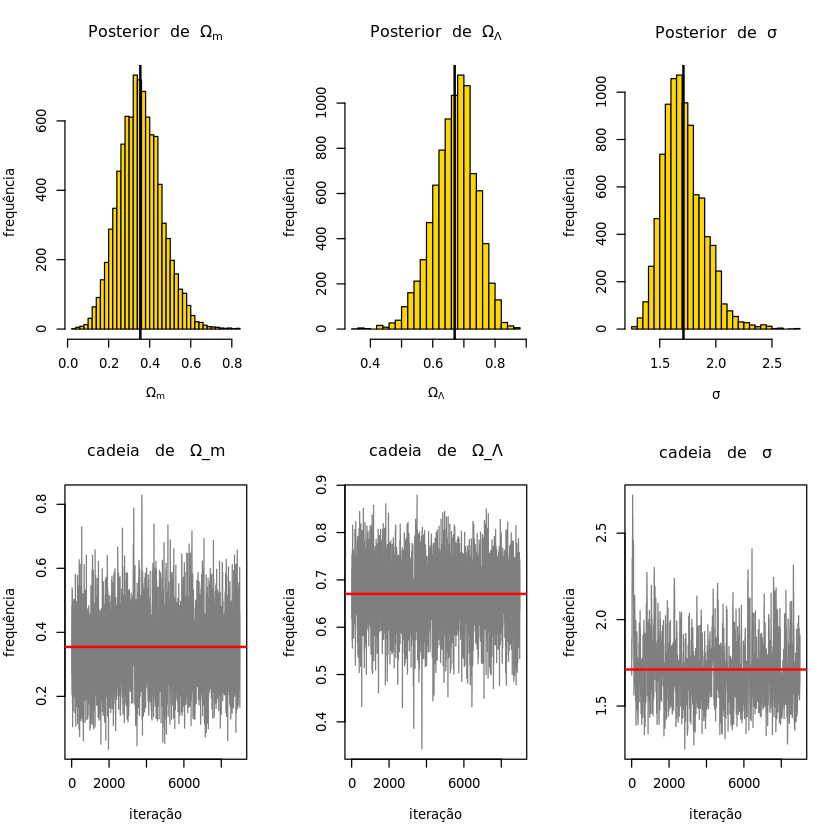

In [257]:
# visualização, sem o burn-in
# a linha vermelha é o valor médio do parâmetro
par(mfrow = c(2,3))

hist(Om_m_sim,breaks=30, main=TeX("$Posterior \\ de \\ \\Omega_m$"), xlab=TeX("$\\Omega_m$"),ylab='frequência',col='gold')
abline(v = mean(Om_m_sim),lwd=2)
hist(Om_l_sim,breaks=30, main=TeX("$Posterior \\ de \\ \\Omega_\\Lambda$"), xlab=TeX("$\\Omega_\\Lambda$"),ylab='frequência',col='gold')
abline(v = mean(Om_l_sim),lwd=2)
hist(sigma_sim,breaks=30, main=TeX("$Posterior \\ de \\ \\sigma$"), xlab=TeX("\\sigma"),ylab='frequência',col='gold')
abline(v = mean(sigma_sim),lwd=2)

plot(Om_m_sim, type = "l", xlab="iteração" , main = TeX("cadeia \\ de \\ \\Omega_m"),ylab='frequência',col='gray50')
abline(h = mean(Om_m_sim), col="red",lwd=2)
plot(Om_l_sim, type = "l", xlab="iteração" , main =  TeX("cadeia \\ de \\ \\Omega_\\Lambda"),ylab='frequência',col='gray50')
abline(h = mean(Om_l_sim), col="red",lwd=2)
plot(sigma_sim, type = "l", xlab="iteração" , main =  TeX("cadeia \\ de \\ \\sigma"),ylab='frequência',col='gray50')
abline(h = mean(sigma_sim), col="red",lwd=2)

In [258]:
summary(Om_m_sim)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03536 0.28253 0.34965 0.35446 0.42116 0.82870 

In [259]:
summary(Om_l_sim)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3425  0.6275  0.6755  0.6704  0.7170  0.8792 

In [260]:
summary(sigma_sim)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.251   1.582   1.688   1.711   1.817   2.720 

In [261]:
mean(Om_l_sim)+1*sd(Om_l_sim)

0.738761202739709

In [262]:
mean(Om_m_sim)-1*sd(Om_m_sim)

0.250438572206925

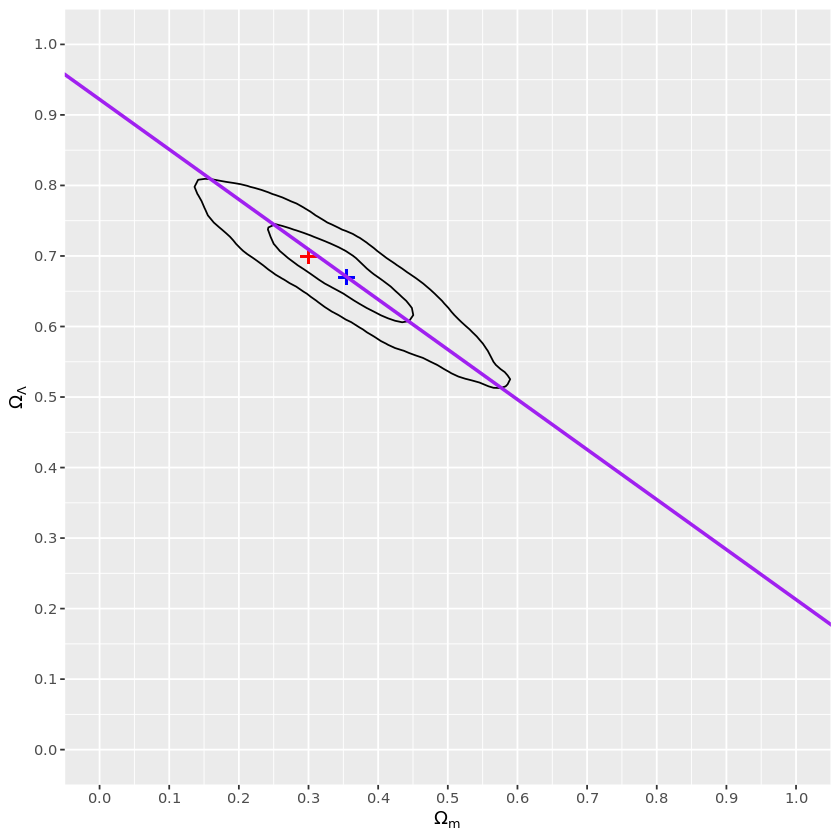

In [286]:
# (vermelho = parametros reais, azul = parametros simulados, linha roxa = restrição aos parametros)
Zc = cbind(Om_m_sim,Om_l_sim)
df <- data.frame(x = Zc[,1], y = Zc[,2])

ggplot(df, aes(x = x, y = y)) +
scale_x_continuous( limits=c(0, 1),breaks=seq(0,1,0.1)) + 
xlab(TeX("$\\Omega_m$")) +
scale_y_continuous(limits=c(0, 1),breaks=seq(0,1,0.1)) +
ylab(TeX("$\\Omega_\\Lambda$")) +
  geom_density_2d(breaks=c(30,6),col='black') +
  geom_point(aes(x = Om_m_0, y = Om_l_0), shape="+", color = "red", size = 5) +
  geom_point(aes(x = mean(Om_m_sim), y = mean(Om_l_sim)), shape="+", color = "blue", size = 5)+
  geom_abline(slope = -1/1.41, intercept = 1.3/1.41, col="purple", lwd=1)